##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate a [Portuguese to English dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/cnn.ipynb). This general architecture has a number of advantages:

* It makes no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Setup

In [2]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

In [3]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [4]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Download the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [5]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

In [6]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Text tokenization & detokenization

You can't train a model directly on text. The text needs to be converted to some numeric representation first. Typically, you convert the text to sequences of token IDs, which are as indexes into an embedding.

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/tutorials/tensorflow_text/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

Download and unzip and import the `saved_model`:

In [7]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

188416/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [8]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portugese. Both have the same methods:

In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [10]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [12]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [13]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serindipity" into "s ##ere ##nd ##ip ##ity"

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

This function will be used to encode the batches of raw text:

In [14]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Here's a simple input pipeline that processes, shuffles and batches the data:

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


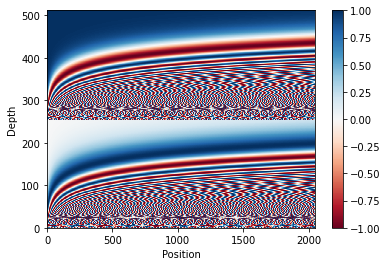

In [19]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn. 

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [25]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [29]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [33]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [35]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [39]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [41]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

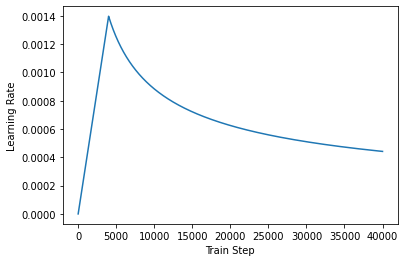

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [51]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [53]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [54]:
EPOCHS = 20

In [55]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [56]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.9100 Accuracy 0.0000


Epoch 1 Batch 50 Loss 8.8356 Accuracy 0.0000


Epoch 1 Batch 100 Loss 8.7204 Accuracy 0.0189


Epoch 1 Batch 150 Loss 8.6013 Accuracy 0.0301


Epoch 1 Batch 200 Loss 8.4595 Accuracy 0.0368


Epoch 1 Batch 250 Loss 8.2902 Accuracy 0.0419


Epoch 1 Batch 300 Loss 8.0998 Accuracy 0.0480


Epoch 1 Batch 350 Loss 7.9023 Accuracy 0.0537


Epoch 1 Batch 400 Loss 7.7121 Accuracy 0.0603


Epoch 1 Batch 450 Loss 7.5456 Accuracy 0.0684


Epoch 1 Batch 500 Loss 7.3958 Accuracy 0.0762


Epoch 1 Batch 550 Loss 7.2616 Accuracy 0.0834


Epoch 1 Batch 600 Loss 7.1360 Accuracy 0.0909


Epoch 1 Batch 650 Loss 7.0193 Accuracy 0.0980


Epoch 1 Batch 700 Loss 6.9098 Accuracy 0.1048


Epoch 1 Batch 750 Loss 6.8094 Accuracy 0.1110


Epoch 1 Batch 800 Loss 6.7171 Accuracy 0.1166


Epoch 1 Loss 6.7009 Accuracy 0.1176
Time taken for 1 epoch: 62.77 secs



Epoch 2 Batch 0 Loss 5.3367 Accuracy 0.1986


Epoch 2 Batch 50 Loss 5.2102 Accuracy 0.2122


Epoch 2 Batch 100 Loss 5.1933 Accuracy 0.2141


Epoch 2 Batch 150 Loss 5.1574 Accuracy 0.2184


Epoch 2 Batch 200 Loss 5.1324 Accuracy 0.2211


Epoch 2 Batch 250 Loss 5.1131 Accuracy 0.2230


Epoch 2 Batch 300 Loss 5.0927 Accuracy 0.2252


Epoch 2 Batch 350 Loss 5.0686 Accuracy 0.2279


Epoch 2 Batch 400 Loss 5.0458 Accuracy 0.2304


Epoch 2 Batch 450 Loss 5.0202 Accuracy 0.2330


Epoch 2 Batch 500 Loss 4.9994 Accuracy 0.2352


Epoch 2 Batch 550 Loss 4.9846 Accuracy 0.2367


Epoch 2 Batch 600 Loss 4.9679 Accuracy 0.2381


Epoch 2 Batch 650 Loss 4.9507 Accuracy 0.2399


Epoch 2 Batch 700 Loss 4.9325 Accuracy 0.2416


Epoch 2 Batch 750 Loss 4.9148 Accuracy 0.2431


Epoch 2 Batch 800 Loss 4.8987 Accuracy 0.2446


Epoch 2 Loss 4.8961 Accuracy 0.2449
Time taken for 1 epoch: 50.23 secs



Epoch 3 Batch 0 Loss 4.4982 Accuracy 0.3001


Epoch 3 Batch 50 Loss 4.5929 Accuracy 0.2684


Epoch 3 Batch 100 Loss 4.5739 Accuracy 0.2724


Epoch 3 Batch 150 Loss 4.5582 Accuracy 0.2744


Epoch 3 Batch 200 Loss 4.5466 Accuracy 0.2755


Epoch 3 Batch 250 Loss 4.5418 Accuracy 0.2764


Epoch 3 Batch 300 Loss 4.5288 Accuracy 0.2779


Epoch 3 Batch 350 Loss 4.5153 Accuracy 0.2796


Epoch 3 Batch 400 Loss 4.4985 Accuracy 0.2813


Epoch 3 Batch 450 Loss 4.4831 Accuracy 0.2831


Epoch 3 Batch 500 Loss 4.4666 Accuracy 0.2851


Epoch 3 Batch 550 Loss 4.4518 Accuracy 0.2869


Epoch 3 Batch 600 Loss 4.4358 Accuracy 0.2888


Epoch 3 Batch 650 Loss 4.4201 Accuracy 0.2908


Epoch 3 Batch 700 Loss 4.4041 Accuracy 0.2927


Epoch 3 Batch 750 Loss 4.3882 Accuracy 0.2945


Epoch 3 Batch 800 Loss 4.3714 Accuracy 0.2966


Epoch 3 Loss 4.3674 Accuracy 0.2971
Time taken for 1 epoch: 49.58 secs



Epoch 4 Batch 0 Loss 4.0688 Accuracy 0.3188


Epoch 4 Batch 50 Loss 4.0178 Accuracy 0.3364


Epoch 4 Batch 100 Loss 4.0144 Accuracy 0.3363


Epoch 4 Batch 150 Loss 3.9990 Accuracy 0.3384


Epoch 4 Batch 200 Loss 3.9837 Accuracy 0.3407


Epoch 4 Batch 250 Loss 3.9590 Accuracy 0.3442


Epoch 4 Batch 300 Loss 3.9439 Accuracy 0.3468


Epoch 4 Batch 350 Loss 3.9256 Accuracy 0.3491


Epoch 4 Batch 400 Loss 3.9088 Accuracy 0.3516


Epoch 4 Batch 450 Loss 3.8955 Accuracy 0.3534


Epoch 4 Batch 500 Loss 3.8801 Accuracy 0.3555


Epoch 4 Batch 550 Loss 3.8677 Accuracy 0.3572


Epoch 4 Batch 600 Loss 3.8543 Accuracy 0.3591


Epoch 4 Batch 650 Loss 3.8413 Accuracy 0.3610


Epoch 4 Batch 700 Loss 3.8278 Accuracy 0.3626


Epoch 4 Batch 750 Loss 3.8151 Accuracy 0.3643


Epoch 4 Batch 800 Loss 3.8018 Accuracy 0.3661


Epoch 4 Loss 3.7992 Accuracy 0.3664
Time taken for 1 epoch: 49.30 secs



Epoch 5 Batch 0 Loss 3.4919 Accuracy 0.4033


Epoch 5 Batch 50 Loss 3.5070 Accuracy 0.3975


Epoch 5 Batch 100 Loss 3.4946 Accuracy 0.4005


Epoch 5 Batch 150 Loss 3.4881 Accuracy 0.4014


Epoch 5 Batch 200 Loss 3.4732 Accuracy 0.4044


Epoch 5 Batch 250 Loss 3.4666 Accuracy 0.4052


Epoch 5 Batch 300 Loss 3.4576 Accuracy 0.4060


Epoch 5 Batch 350 Loss 3.4427 Accuracy 0.4083


Epoch 5 Batch 400 Loss 3.4292 Accuracy 0.4102


Epoch 5 Batch 450 Loss 3.4159 Accuracy 0.4121


Epoch 5 Batch 500 Loss 3.4036 Accuracy 0.4137


Epoch 5 Batch 550 Loss 3.3930 Accuracy 0.4152


Epoch 5 Batch 600 Loss 3.3852 Accuracy 0.4163


Epoch 5 Batch 650 Loss 3.3783 Accuracy 0.4172


Epoch 5 Batch 700 Loss 3.3682 Accuracy 0.4186


Epoch 5 Batch 750 Loss 3.3597 Accuracy 0.4197


Epoch 5 Batch 800 Loss 3.3512 Accuracy 0.4209


Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 3.3500 Accuracy 0.4209
Time taken for 1 epoch: 50.38 secs



Epoch 6 Batch 0 Loss 2.7326 Accuracy 0.4912


Epoch 6 Batch 50 Loss 3.0709 Accuracy 0.4535


Epoch 6 Batch 100 Loss 3.0605 Accuracy 0.4557


Epoch 6 Batch 150 Loss 3.0550 Accuracy 0.4566


Epoch 6 Batch 200 Loss 3.0579 Accuracy 0.4564


Epoch 6 Batch 250 Loss 3.0414 Accuracy 0.4586


Epoch 6 Batch 300 Loss 3.0309 Accuracy 0.4606


Epoch 6 Batch 350 Loss 3.0224 Accuracy 0.4614


Epoch 6 Batch 400 Loss 3.0133 Accuracy 0.4624


Epoch 6 Batch 450 Loss 3.0020 Accuracy 0.4639


Epoch 6 Batch 500 Loss 2.9945 Accuracy 0.4650


Epoch 6 Batch 550 Loss 2.9890 Accuracy 0.4660


Epoch 6 Batch 600 Loss 2.9801 Accuracy 0.4672


Epoch 6 Batch 650 Loss 2.9739 Accuracy 0.4681


Epoch 6 Batch 700 Loss 2.9649 Accuracy 0.4694


Epoch 6 Batch 750 Loss 2.9566 Accuracy 0.4705


Epoch 6 Batch 800 Loss 2.9511 Accuracy 0.4712


Epoch 6 Loss 2.9493 Accuracy 0.4715
Time taken for 1 epoch: 50.79 secs



Epoch 7 Batch 0 Loss 2.5923 Accuracy 0.5178


Epoch 7 Batch 50 Loss 2.7039 Accuracy 0.5011


Epoch 7 Batch 100 Loss 2.6967 Accuracy 0.5013


Epoch 7 Batch 150 Loss 2.6928 Accuracy 0.5017


Epoch 7 Batch 200 Loss 2.6884 Accuracy 0.5025


Epoch 7 Batch 250 Loss 2.6836 Accuracy 0.5029


Epoch 7 Batch 300 Loss 2.6736 Accuracy 0.5046


Epoch 7 Batch 350 Loss 2.6701 Accuracy 0.5052


Epoch 7 Batch 400 Loss 2.6645 Accuracy 0.5061


Epoch 7 Batch 450 Loss 2.6616 Accuracy 0.5065


Epoch 7 Batch 500 Loss 2.6530 Accuracy 0.5079


Epoch 7 Batch 550 Loss 2.6468 Accuracy 0.5088


Epoch 7 Batch 600 Loss 2.6410 Accuracy 0.5097


Epoch 7 Batch 650 Loss 2.6367 Accuracy 0.5105


Epoch 7 Batch 700 Loss 2.6331 Accuracy 0.5110


Epoch 7 Batch 750 Loss 2.6284 Accuracy 0.5119


Epoch 7 Batch 800 Loss 2.6259 Accuracy 0.5123


Epoch 7 Loss 2.6256 Accuracy 0.5124
Time taken for 1 epoch: 50.15 secs



Epoch 8 Batch 0 Loss 2.0821 Accuracy 0.5868


Epoch 8 Batch 50 Loss 2.4047 Accuracy 0.5410


Epoch 8 Batch 100 Loss 2.4083 Accuracy 0.5394


Epoch 8 Batch 150 Loss 2.4116 Accuracy 0.5393


Epoch 8 Batch 200 Loss 2.4099 Accuracy 0.5397


Epoch 8 Batch 250 Loss 2.4124 Accuracy 0.5391


Epoch 8 Batch 300 Loss 2.4089 Accuracy 0.5395


Epoch 8 Batch 350 Loss 2.4047 Accuracy 0.5404


Epoch 8 Batch 400 Loss 2.4027 Accuracy 0.5407


Epoch 8 Batch 450 Loss 2.4025 Accuracy 0.5407


Epoch 8 Batch 500 Loss 2.4000 Accuracy 0.5412


Epoch 8 Batch 550 Loss 2.3966 Accuracy 0.5420


Epoch 8 Batch 600 Loss 2.3945 Accuracy 0.5423


Epoch 8 Batch 650 Loss 2.3957 Accuracy 0.5422


Epoch 8 Batch 700 Loss 2.3934 Accuracy 0.5426


Epoch 8 Batch 750 Loss 2.3945 Accuracy 0.5426


Epoch 8 Batch 800 Loss 2.3913 Accuracy 0.5431


Epoch 8 Loss 2.3909 Accuracy 0.5432
Time taken for 1 epoch: 50.24 secs



Epoch 9 Batch 0 Loss 2.2065 Accuracy 0.5583


Epoch 9 Batch 50 Loss 2.2045 Accuracy 0.5660


Epoch 9 Batch 100 Loss 2.2084 Accuracy 0.5668


Epoch 9 Batch 150 Loss 2.2118 Accuracy 0.5665


Epoch 9 Batch 200 Loss 2.2072 Accuracy 0.5677


Epoch 9 Batch 250 Loss 2.2118 Accuracy 0.5668


Epoch 9 Batch 300 Loss 2.2182 Accuracy 0.5663


Epoch 9 Batch 350 Loss 2.2157 Accuracy 0.5665


Epoch 9 Batch 400 Loss 2.2184 Accuracy 0.5662


Epoch 9 Batch 450 Loss 2.2162 Accuracy 0.5667


Epoch 9 Batch 500 Loss 2.2162 Accuracy 0.5669


Epoch 9 Batch 550 Loss 2.2137 Accuracy 0.5674


Epoch 9 Batch 600 Loss 2.2144 Accuracy 0.5672


Epoch 9 Batch 650 Loss 2.2145 Accuracy 0.5674


Epoch 9 Batch 700 Loss 2.2142 Accuracy 0.5676


Epoch 9 Batch 750 Loss 2.2136 Accuracy 0.5678


Epoch 9 Batch 800 Loss 2.2143 Accuracy 0.5677


Epoch 9 Loss 2.2153 Accuracy 0.5676
Time taken for 1 epoch: 50.02 secs



Epoch 10 Batch 0 Loss 2.2510 Accuracy 0.5560


Epoch 10 Batch 50 Loss 2.0568 Accuracy 0.5881


Epoch 10 Batch 100 Loss 2.0707 Accuracy 0.5854


Epoch 10 Batch 150 Loss 2.0704 Accuracy 0.5862


Epoch 10 Batch 200 Loss 2.0712 Accuracy 0.5863


Epoch 10 Batch 250 Loss 2.0676 Accuracy 0.5870


Epoch 10 Batch 300 Loss 2.0712 Accuracy 0.5864


Epoch 10 Batch 350 Loss 2.0699 Accuracy 0.5867


Epoch 10 Batch 400 Loss 2.0720 Accuracy 0.5864


Epoch 10 Batch 450 Loss 2.0706 Accuracy 0.5868


Epoch 10 Batch 500 Loss 2.0726 Accuracy 0.5866


Epoch 10 Batch 550 Loss 2.0770 Accuracy 0.5860


Epoch 10 Batch 600 Loss 2.0757 Accuracy 0.5863


Epoch 10 Batch 650 Loss 2.0770 Accuracy 0.5863


Epoch 10 Batch 700 Loss 2.0794 Accuracy 0.5860


Epoch 10 Batch 750 Loss 2.0783 Accuracy 0.5865


Epoch 10 Batch 800 Loss 2.0773 Accuracy 0.5868


Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 2.0783 Accuracy 0.5867
Time taken for 1 epoch: 50.45 secs



Epoch 11 Batch 0 Loss 2.1780 Accuracy 0.5496


Epoch 11 Batch 50 Loss 1.9558 Accuracy 0.6021


Epoch 11 Batch 100 Loss 1.9544 Accuracy 0.6036


Epoch 11 Batch 150 Loss 1.9594 Accuracy 0.6024


Epoch 11 Batch 200 Loss 1.9580 Accuracy 0.6032


Epoch 11 Batch 250 Loss 1.9611 Accuracy 0.6026


Epoch 11 Batch 300 Loss 1.9605 Accuracy 0.6024


Epoch 11 Batch 350 Loss 1.9613 Accuracy 0.6026


Epoch 11 Batch 400 Loss 1.9622 Accuracy 0.6024


Epoch 11 Batch 450 Loss 1.9624 Accuracy 0.6025


Epoch 11 Batch 500 Loss 1.9636 Accuracy 0.6022


Epoch 11 Batch 550 Loss 1.9651 Accuracy 0.6023


Epoch 11 Batch 600 Loss 1.9660 Accuracy 0.6022


Epoch 11 Batch 650 Loss 1.9666 Accuracy 0.6021


Epoch 11 Batch 700 Loss 1.9682 Accuracy 0.6019


Epoch 11 Batch 750 Loss 1.9691 Accuracy 0.6019


Epoch 11 Batch 800 Loss 1.9684 Accuracy 0.6022


Epoch 11 Loss 1.9684 Accuracy 0.6023
Time taken for 1 epoch: 49.93 secs



Epoch 12 Batch 0 Loss 2.0619 Accuracy 0.5867


Epoch 12 Batch 50 Loss 1.8266 Accuracy 0.6231


Epoch 12 Batch 100 Loss 1.8458 Accuracy 0.6203


Epoch 12 Batch 150 Loss 1.8579 Accuracy 0.6175


Epoch 12 Batch 200 Loss 1.8604 Accuracy 0.6173


Epoch 12 Batch 250 Loss 1.8588 Accuracy 0.6179


Epoch 12 Batch 300 Loss 1.8587 Accuracy 0.6179


Epoch 12 Batch 350 Loss 1.8588 Accuracy 0.6180


Epoch 12 Batch 400 Loss 1.8620 Accuracy 0.6175


Epoch 12 Batch 450 Loss 1.8633 Accuracy 0.6174


Epoch 12 Batch 500 Loss 1.8645 Accuracy 0.6171


Epoch 12 Batch 550 Loss 1.8662 Accuracy 0.6168


Epoch 12 Batch 600 Loss 1.8680 Accuracy 0.6167


Epoch 12 Batch 650 Loss 1.8693 Accuracy 0.6165


Epoch 12 Batch 700 Loss 1.8712 Accuracy 0.6165


Epoch 12 Batch 750 Loss 1.8724 Accuracy 0.6164


Epoch 12 Batch 800 Loss 1.8736 Accuracy 0.6163


Epoch 12 Loss 1.8738 Accuracy 0.6163
Time taken for 1 epoch: 50.68 secs



Epoch 13 Batch 0 Loss 1.6363 Accuracy 0.6542


Epoch 13 Batch 50 Loss 1.7369 Accuracy 0.6358


Epoch 13 Batch 100 Loss 1.7542 Accuracy 0.6321


Epoch 13 Batch 150 Loss 1.7633 Accuracy 0.6302


Epoch 13 Batch 200 Loss 1.7693 Accuracy 0.6293


Epoch 13 Batch 250 Loss 1.7778 Accuracy 0.6286


Epoch 13 Batch 300 Loss 1.7800 Accuracy 0.6285


Epoch 13 Batch 350 Loss 1.7840 Accuracy 0.6278


Epoch 13 Batch 400 Loss 1.7855 Accuracy 0.6277


Epoch 13 Batch 450 Loss 1.7845 Accuracy 0.6279


Epoch 13 Batch 500 Loss 1.7837 Accuracy 0.6281


Epoch 13 Batch 550 Loss 1.7856 Accuracy 0.6279


Epoch 13 Batch 600 Loss 1.7884 Accuracy 0.6276


Epoch 13 Batch 650 Loss 1.7907 Accuracy 0.6274


Epoch 13 Batch 700 Loss 1.7921 Accuracy 0.6275


Epoch 13 Batch 750 Loss 1.7938 Accuracy 0.6273


Epoch 13 Batch 800 Loss 1.7959 Accuracy 0.6271


Epoch 13 Loss 1.7955 Accuracy 0.6272
Time taken for 1 epoch: 51.56 secs



Epoch 14 Batch 0 Loss 1.7589 Accuracy 0.6225


Epoch 14 Batch 50 Loss 1.6739 Accuracy 0.6436


Epoch 14 Batch 100 Loss 1.6871 Accuracy 0.6421


Epoch 14 Batch 150 Loss 1.6937 Accuracy 0.6416


Epoch 14 Batch 200 Loss 1.6950 Accuracy 0.6415


Epoch 14 Batch 250 Loss 1.6975 Accuracy 0.6415


Epoch 14 Batch 300 Loss 1.6951 Accuracy 0.6418


Epoch 14 Batch 350 Loss 1.7000 Accuracy 0.6411


Epoch 14 Batch 400 Loss 1.7041 Accuracy 0.6407


Epoch 14 Batch 450 Loss 1.7068 Accuracy 0.6402


Epoch 14 Batch 500 Loss 1.7096 Accuracy 0.6399


Epoch 14 Batch 550 Loss 1.7104 Accuracy 0.6398


Epoch 14 Batch 600 Loss 1.7128 Accuracy 0.6394


Epoch 14 Batch 650 Loss 1.7166 Accuracy 0.6388


Epoch 14 Batch 700 Loss 1.7200 Accuracy 0.6382


Epoch 14 Batch 750 Loss 1.7228 Accuracy 0.6379


Epoch 14 Batch 800 Loss 1.7256 Accuracy 0.6375


Epoch 14 Loss 1.7268 Accuracy 0.6374
Time taken for 1 epoch: 51.95 secs



Epoch 15 Batch 0 Loss 1.6051 Accuracy 0.6474


Epoch 15 Batch 50 Loss 1.6280 Accuracy 0.6511


Epoch 15 Batch 100 Loss 1.6313 Accuracy 0.6497


Epoch 15 Batch 150 Loss 1.6378 Accuracy 0.6503


Epoch 15 Batch 200 Loss 1.6409 Accuracy 0.6502


Epoch 15 Batch 250 Loss 1.6412 Accuracy 0.6502


Epoch 15 Batch 300 Loss 1.6407 Accuracy 0.6505


Epoch 15 Batch 350 Loss 1.6438 Accuracy 0.6497


Epoch 15 Batch 400 Loss 1.6457 Accuracy 0.6492


Epoch 15 Batch 450 Loss 1.6487 Accuracy 0.6489


Epoch 15 Batch 500 Loss 1.6520 Accuracy 0.6485


Epoch 15 Batch 550 Loss 1.6559 Accuracy 0.6480


Epoch 15 Batch 600 Loss 1.6572 Accuracy 0.6477


Epoch 15 Batch 650 Loss 1.6595 Accuracy 0.6475


Epoch 15 Batch 700 Loss 1.6608 Accuracy 0.6474


Epoch 15 Batch 750 Loss 1.6632 Accuracy 0.6471


Epoch 15 Batch 800 Loss 1.6663 Accuracy 0.6466


Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 1.6664 Accuracy 0.6467
Time taken for 1 epoch: 51.73 secs



Epoch 16 Batch 0 Loss 1.6299 Accuracy 0.6467


Epoch 16 Batch 50 Loss 1.5914 Accuracy 0.6572


Epoch 16 Batch 100 Loss 1.5856 Accuracy 0.6581


Epoch 16 Batch 150 Loss 1.5843 Accuracy 0.6588


Epoch 16 Batch 200 Loss 1.5905 Accuracy 0.6575


Epoch 16 Batch 250 Loss 1.5917 Accuracy 0.6577


Epoch 16 Batch 300 Loss 1.5925 Accuracy 0.6574


Epoch 16 Batch 350 Loss 1.5928 Accuracy 0.6573


Epoch 16 Batch 400 Loss 1.5958 Accuracy 0.6570


Epoch 16 Batch 450 Loss 1.5962 Accuracy 0.6568


Epoch 16 Batch 500 Loss 1.5995 Accuracy 0.6563


Epoch 16 Batch 550 Loss 1.6030 Accuracy 0.6559


Epoch 16 Batch 600 Loss 1.6029 Accuracy 0.6559


Epoch 16 Batch 650 Loss 1.6027 Accuracy 0.6562


Epoch 16 Batch 700 Loss 1.6062 Accuracy 0.6557


Epoch 16 Batch 750 Loss 1.6095 Accuracy 0.6553


Epoch 16 Batch 800 Loss 1.6130 Accuracy 0.6549


Epoch 16 Loss 1.6133 Accuracy 0.6549
Time taken for 1 epoch: 51.53 secs



Epoch 17 Batch 0 Loss 1.5703 Accuracy 0.6669


Epoch 17 Batch 50 Loss 1.5117 Accuracy 0.6696


Epoch 17 Batch 100 Loss 1.5209 Accuracy 0.6684


Epoch 17 Batch 150 Loss 1.5284 Accuracy 0.6669


Epoch 17 Batch 200 Loss 1.5316 Accuracy 0.6663


Epoch 17 Batch 250 Loss 1.5378 Accuracy 0.6653


Epoch 17 Batch 300 Loss 1.5382 Accuracy 0.6655


Epoch 17 Batch 350 Loss 1.5406 Accuracy 0.6650


Epoch 17 Batch 400 Loss 1.5433 Accuracy 0.6644


Epoch 17 Batch 450 Loss 1.5459 Accuracy 0.6641


Epoch 17 Batch 500 Loss 1.5509 Accuracy 0.6633


Epoch 17 Batch 550 Loss 1.5507 Accuracy 0.6634


Epoch 17 Batch 600 Loss 1.5524 Accuracy 0.6632


Epoch 17 Batch 650 Loss 1.5565 Accuracy 0.6626


Epoch 17 Batch 700 Loss 1.5592 Accuracy 0.6622


Epoch 17 Batch 750 Loss 1.5617 Accuracy 0.6619


Epoch 17 Batch 800 Loss 1.5647 Accuracy 0.6615


Epoch 17 Loss 1.5648 Accuracy 0.6615
Time taken for 1 epoch: 51.79 secs



Epoch 18 Batch 0 Loss 1.6312 Accuracy 0.6418


Epoch 18 Batch 50 Loss 1.4663 Accuracy 0.6776


Epoch 18 Batch 100 Loss 1.4787 Accuracy 0.6749


Epoch 18 Batch 150 Loss 1.4886 Accuracy 0.6736


Epoch 18 Batch 200 Loss 1.4921 Accuracy 0.6734


Epoch 18 Batch 250 Loss 1.4908 Accuracy 0.6739


Epoch 18 Batch 300 Loss 1.4935 Accuracy 0.6735


Epoch 18 Batch 350 Loss 1.4975 Accuracy 0.6724


Epoch 18 Batch 400 Loss 1.4988 Accuracy 0.6722


Epoch 18 Batch 450 Loss 1.5011 Accuracy 0.6717


Epoch 18 Batch 500 Loss 1.5025 Accuracy 0.6716


Epoch 18 Batch 550 Loss 1.5069 Accuracy 0.6708


Epoch 18 Batch 600 Loss 1.5089 Accuracy 0.6704


Epoch 18 Batch 650 Loss 1.5114 Accuracy 0.6701


Epoch 18 Batch 700 Loss 1.5133 Accuracy 0.6699


Epoch 18 Batch 750 Loss 1.5155 Accuracy 0.6697


Epoch 18 Batch 800 Loss 1.5197 Accuracy 0.6692


Epoch 18 Loss 1.5196 Accuracy 0.6692
Time taken for 1 epoch: 51.27 secs



Epoch 19 Batch 0 Loss 1.3096 Accuracy 0.7138


Epoch 19 Batch 50 Loss 1.4316 Accuracy 0.6818


Epoch 19 Batch 100 Loss 1.4265 Accuracy 0.6827


Epoch 19 Batch 150 Loss 1.4351 Accuracy 0.6816


Epoch 19 Batch 200 Loss 1.4462 Accuracy 0.6795


Epoch 19 Batch 250 Loss 1.4518 Accuracy 0.6788


Epoch 19 Batch 300 Loss 1.4582 Accuracy 0.6781


Epoch 19 Batch 350 Loss 1.4591 Accuracy 0.6784


Epoch 19 Batch 400 Loss 1.4607 Accuracy 0.6782


Epoch 19 Batch 450 Loss 1.4627 Accuracy 0.6779


Epoch 19 Batch 500 Loss 1.4636 Accuracy 0.6780


Epoch 19 Batch 550 Loss 1.4667 Accuracy 0.6775


Epoch 19 Batch 600 Loss 1.4682 Accuracy 0.6773


Epoch 19 Batch 650 Loss 1.4714 Accuracy 0.6768


Epoch 19 Batch 700 Loss 1.4742 Accuracy 0.6764


Epoch 19 Batch 750 Loss 1.4776 Accuracy 0.6757


Epoch 19 Batch 800 Loss 1.4810 Accuracy 0.6753


Epoch 19 Loss 1.4810 Accuracy 0.6754
Time taken for 1 epoch: 50.62 secs



Epoch 20 Batch 0 Loss 1.2899 Accuracy 0.7115


Epoch 20 Batch 50 Loss 1.3791 Accuracy 0.6902


Epoch 20 Batch 100 Loss 1.3859 Accuracy 0.6901


Epoch 20 Batch 150 Loss 1.3991 Accuracy 0.6880


Epoch 20 Batch 200 Loss 1.4079 Accuracy 0.6867


Epoch 20 Batch 250 Loss 1.4115 Accuracy 0.6861


Epoch 20 Batch 300 Loss 1.4128 Accuracy 0.6858


Epoch 20 Batch 350 Loss 1.4180 Accuracy 0.6848


Epoch 20 Batch 400 Loss 1.4174 Accuracy 0.6850


Epoch 20 Batch 450 Loss 1.4209 Accuracy 0.6848


Epoch 20 Batch 500 Loss 1.4236 Accuracy 0.6844


Epoch 20 Batch 550 Loss 1.4280 Accuracy 0.6836


Epoch 20 Batch 600 Loss 1.4324 Accuracy 0.6828


Epoch 20 Batch 650 Loss 1.4337 Accuracy 0.6827


Epoch 20 Batch 700 Loss 1.4365 Accuracy 0.6822


Epoch 20 Batch 750 Loss 1.4391 Accuracy 0.6818


Epoch 20 Batch 800 Loss 1.4432 Accuracy 0.6813


Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 1.4440 Accuracy 0.6812
Time taken for 1 epoch: 51.88 secs



## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* The model makes predictions of the next word for each word in the output. Most of these are redundant. Use the predictions from the last word.
* Concatenate the predicted word to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [57]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [58]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [59]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [60]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [61]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly to share with you some magic stories that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

## Attention plots

The `evaluate` function also returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [62]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [63]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [64]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [65]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [66]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

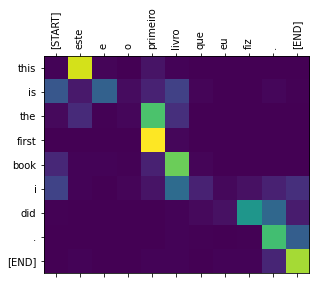

In [67]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [68]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

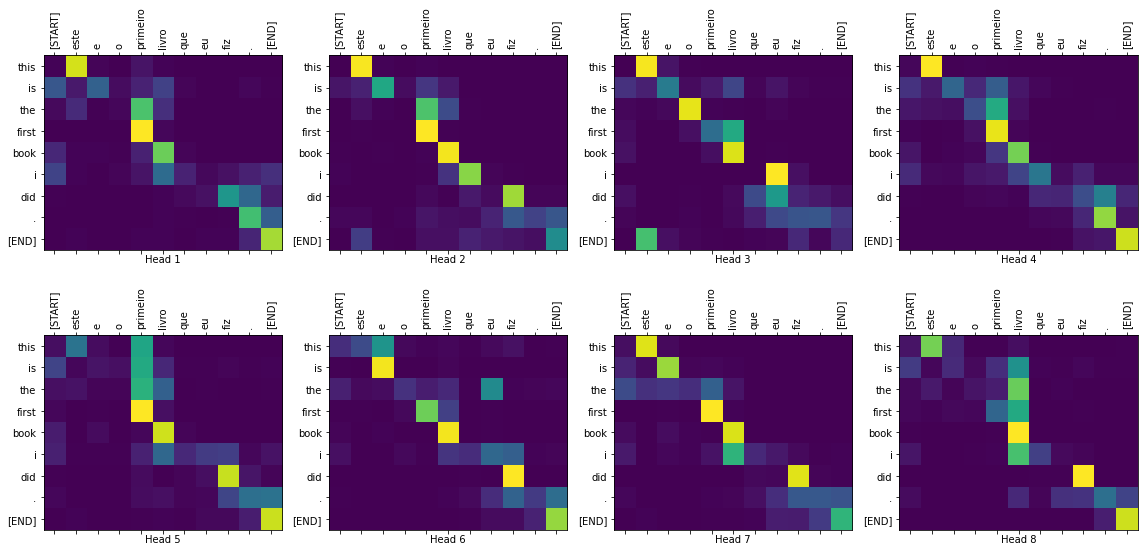

In [69]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about tribrushes in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


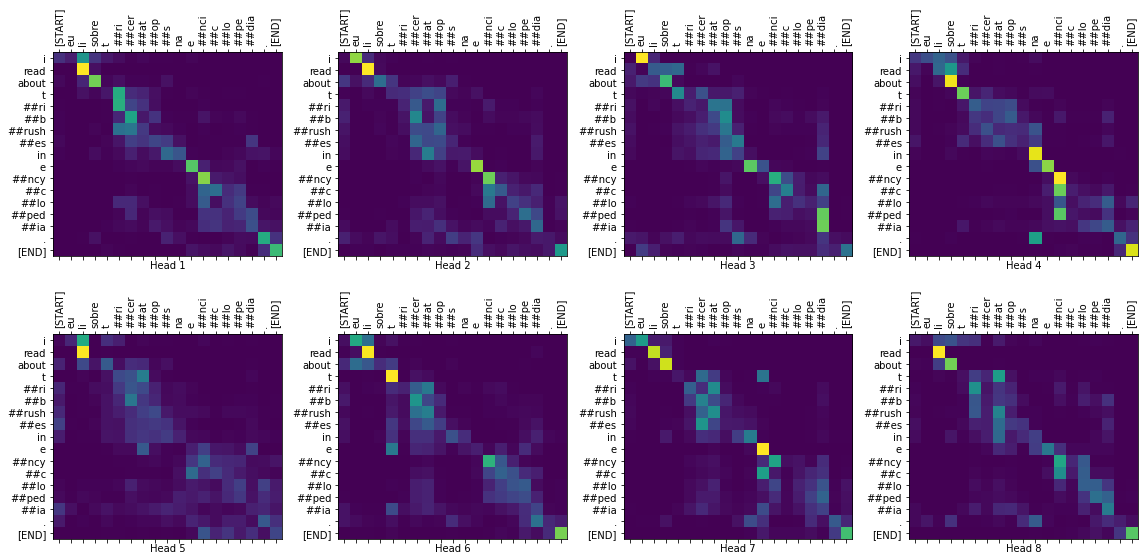

In [70]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Furthermore, you can implement beam search to get better predictions.